Выполнено Олейник Софией в рамках дисциплины "Аналитика данных на Python" магистратуры ИТМО.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# считываем данные с явным указанием типа
data = pd.read_csv(
    "data/Econom_Cities_data.csv",
    sep=";",
    decimal=",",
    dtype = {
        "City": str,
        "Work": int,
        "Price": float,
        "Salary": float
    }
)
data.set_index("City", inplace=True)
data.head()

,Work,Price,Salary
City,,,
Amsterdam,1714,65.6,49.0
Athens,1792,53.8,30.4
Bogota,2152,37.9,11.5
Bombay,2052,30.3,5.3
Brussels,1708,73.8,50.5


In [4]:
# очистка данных от выбросов
data_cleaned = data.copy()
for col in data.columns:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    data_cleaned = data_cleaned[(data_cleaned[col] >= lower) & (data_cleaned[col] <= upper)]

In [5]:
# стандартизация данных
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_cleaned)
data_scaled = pd.DataFrame(data_scaled, columns=data_cleaned.columns, index=data_cleaned.index)

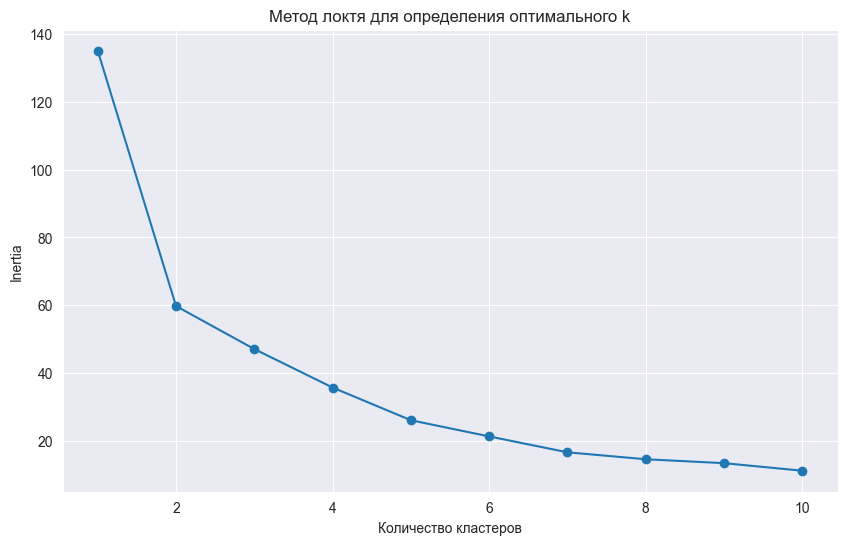

In [6]:
# метод локтя для определения оптимального количества кластеров
inertia = []
k_range = range(1, 11)

# делим данные от 1 до 11 кластеров и смотрим на изменение суммы квадратов расстояний точек до центроид
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(data_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Количество кластеров')
plt.ylabel('Inertia')
plt.title('Метод локтя для определения оптимального k')
plt.grid(True)
plt.show()

Видно, что после 5 кластеров происходит уже не такое значительное изменение кластеров. Можно остановиться на 5 кластерах, поскольку при больших количествах расстояние до центроид уже практически не меняется - значит, алгоритм пришел к оптимальному результату.

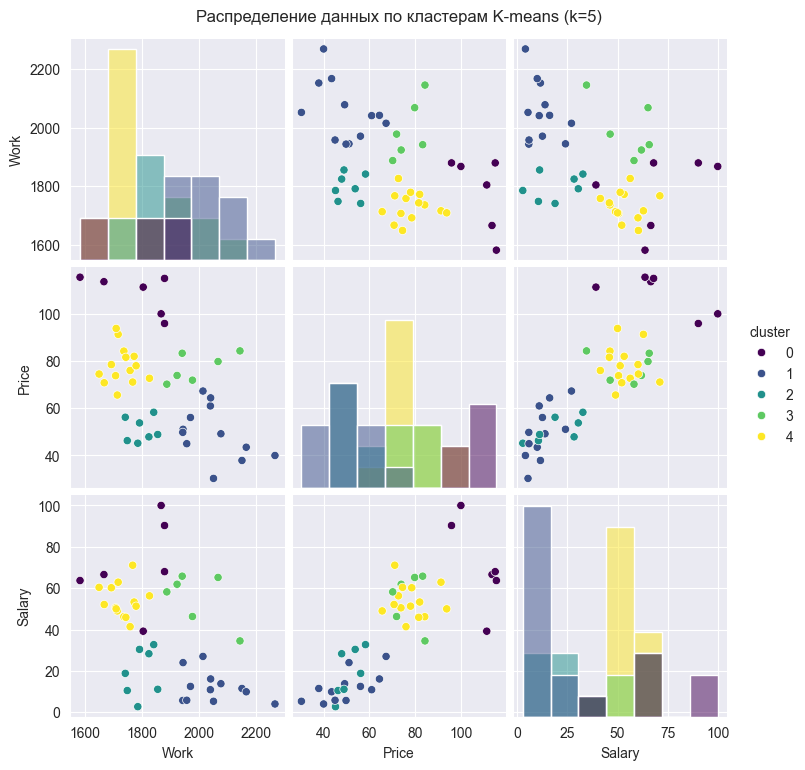

In [7]:
# кластеризация с оптимальным количеством кластеров
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
data_cleaned['cluster'] = kmeans.fit_predict(data_scaled)

# визуализация кластеров
sns.pairplot(data_cleaned, hue='cluster', palette='viridis', diag_kind='hist')
plt.suptitle(f'Распределение данных по кластерам K-means (k={optimal_k})', y=1.02)
plt.show()

In [8]:
# анализ центроидов кластеров
centroids = pd.DataFrame(
    # приводим значения центроид обратно в нестандартизированный вид
    scaler.inverse_transform(kmeans.cluster_centers_),
    columns=data_cleaned.columns[:-1]
)
centroids['cluster'] = range(optimal_k)

print("Центроиды кластеров:")
print(centroids)

print("\nСтатистика по кластерам:")
print(data_cleaned.groupby('cluster').describe())

Центроиды кластеров:
          Work       Price     Salary  cluster
0  1780.500000  108.550000  71.300000        0
1  2052.750000   49.633333  12.208333        1
2  1798.857143   50.942857  19.214286        2
3  1990.833333   77.233333  55.316667        3
4  1732.000000   78.135714  53.614286        4

Статистика по кластерам:
         Work                                                             \
        count         mean         std     min      25%     50%      75%   
cluster                                                                    
0         6.0  1780.500000  126.448013  1583.0  1701.50  1836.5  1877.00   
1        12.0  2052.750000  100.295133  1944.0  1967.75  2041.5  2096.50   
2         7.0  1798.857143   44.235840  1742.0  1767.50  1792.0  1833.50   
3         6.0  1990.833333   97.275725  1888.0  1928.50  1960.0  2045.50   
4        14.0  1732.000000   47.356260  1650.0  1708.50  1727.0  1765.75   

                Price              ...                 Salary 

Если посмотреть на показатели центроид кластеров, которые отражают средние значения кластеров, то можно увидеть, что:
- для 0 кластера: самый высокий уровень цен и зарплаты, при этом умеренное количество рабочих часов. Скорее всего, к этому кластеру отнеслись крупные города с высоким уровнем жизни.
- для 1 кластера: самое высокое количество рабочих часов и самые низкие индексы цен и зарплаты. В этом кластере находятся города с низким уровнем жизни, поскольку жителям для полноценной жизни нужно много работать.
- ко 2 кластеру можно отнести города со сбалансированным количеством часов работы, но при этом низкими ценами и зарплатами - города со средним уровнем жизни.
- к 3 кластеру относятся города с переработками, но средними показателями цен и зарплат. Такие города имеют, скорее всего, низкий уровень жизни.
- к 4 кластеру относятся города со средними показателями количества часов работы, зарплат и цен.

Text(0, 0.5, 'Количество городов')

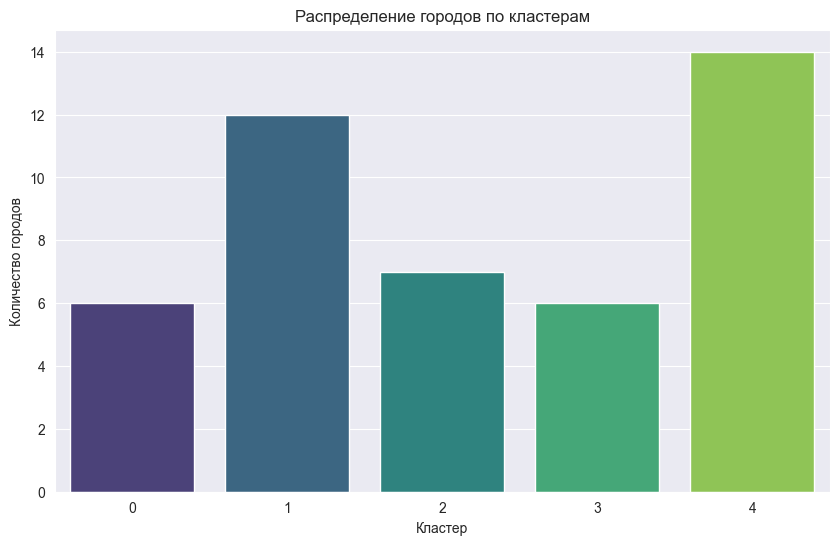

In [9]:
# распределение городов по кластерам
plt.figure(figsize=(10, 6))
sns.countplot(data=data_cleaned, x='cluster', palette='viridis')
plt.title('Распределение городов по кластерам')
plt.xlabel('Кластер')
plt.ylabel('Количество городов')

Города по кластерам распределены примерно равномерно, однако кластеры 1 и 4 с низким и средним уровнями жизни выделяются.